# Trading with Simple Moving Average
> Stock trading is a diffuse practice. In 2020, 55 percent of adults in the United States invested in the stock market. This figure has remained steady over the last few years, and is still below the levels before the Great Recession, when it peaked in 2007 at 65 percent (Gallup [link](https://news.gallup.com/poll/1711/stock-market.aspx), 2021). However, stock trading consists of a large set of different trading strategies. To shed the light on trading strategies that entail moving average-oscillator, we propose the following educational notebook. 

- toc: true 
- badges: true
- hide_binder_badge: true
- comments: true
- categories: [Trading strategy, Moving Average Oscillators, Eikon Data API, Refinitiv product, Simple Moving Average, Visualization, Vectorized Backtesting]
- image: images/trading.png




## Moving average-oscillators

Stock price series are volative. 

To smooth out such a volatile series, we apply the moving average (MA) rule. According to the MA rule, two MAs of the stock price (a long period and a short period average) generate buy and sell signals. Specifically, we buy (or sell) when the short period average rises above (or falls below) the long period one.

Brock, W., Lakonishok, J., & Lebaron, B. (1992). Simple Technical Trading Rules and the Stochastic Properties of Stock Returns (Vol 47, bll 1731–1764).

Importing required package

In [ ]:
import eikon as ek  # the Eikon Python wrapper package
import numpy as np  # NumPy
import pandas as pd  # pandas
import cufflinks as cf  # Cufflinks
import configparser as cp

Connecting to Eikon Data API

In [ ]:
ek.set_app_key('d6afdaa2e0d046dd945d1857d822079a4704ceb6')

## Retrieving End-of-Day data
As an example, we retrieve the end-of-the-day stock prices of Amazon.com from January the 1st, 2010 to December the 1st, 2021. 

In [ ]:
ric = 'AMZN.O'

In [ ]:
data = ek.get_timeseries(ric, 
                         fields = 'CLOSE',
                         start_date='2010-01-01',
                         end_date='2021-12-01'
                        )

In [ ]:
data.head()

AMZN.O,CLOSE
Date,
2010-01-04,133.9
2010-01-05,134.69
2010-01-06,132.25
2010-01-07,130.0
2010-01-08,133.52


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000 entries, 2010-01-04 to 2021-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CLOSE   3000 non-null   Float64
dtypes: Float64(1)
memory usage: 49.8 KB


In [ ]:
data.normalize().iplot(kind='lines')

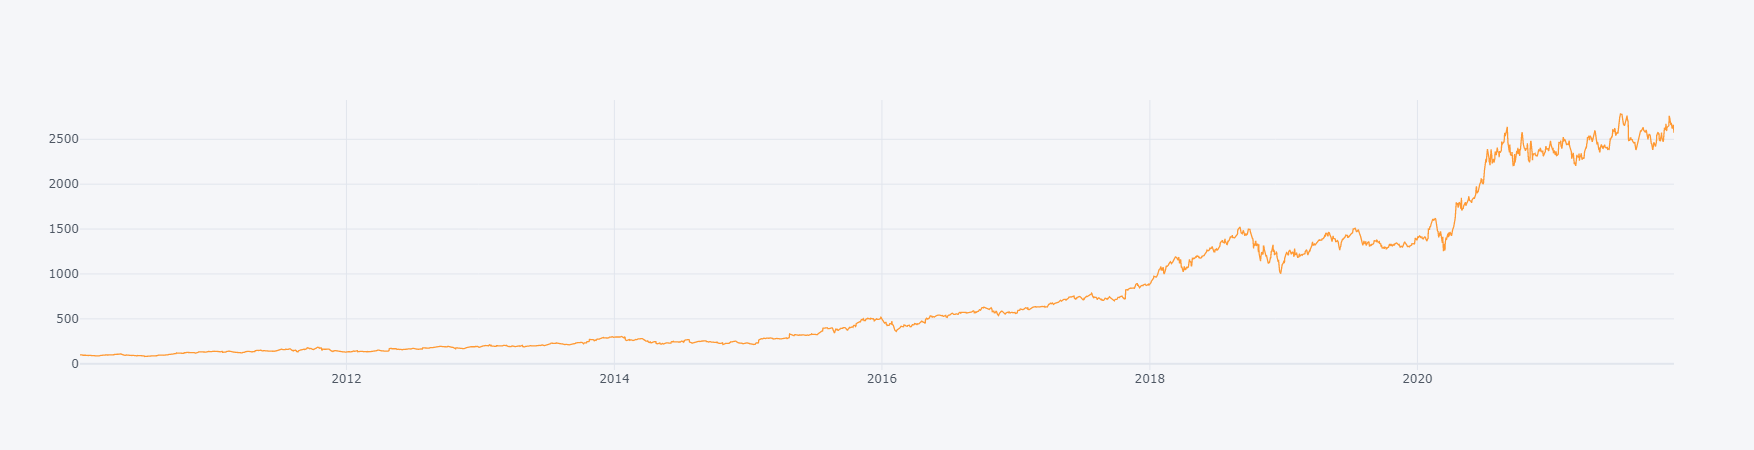

In the above cell, we visualize the stock price time-series of Amazon.com in US dollars. We can see that the price has grown 2600% over almost 10 years.    

## Deriving the SMA Values 

We choose 42 days as the short period and 252 days as the long period. Luckly, `pandas` provides convenience methods to calculate rolling statistics, such as SMAs, in a standardized way.

In [ ]:
SMA1 = 42 
SMA2 = 252

In [ ]:
data['SMA1'] = data['CLOSE'].rolling(SMA1).mean()
data['SMA2'] = data['CLOSE'].rolling(SMA2).mean()

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.tail()

AMZN.O,CLOSE,SMA1,SMA2
Date,,,
2021-11-24,3580.41,3409.934286,3320.637857
2021-11-26,3504.56,3414.424762,3321.905675
2021-11-29,3561.57,3420.625952,3323.358968
2021-11-30,3507.07,3425.912381,3324.704325
2021-12-01,3443.72,3429.732857,3325.591786


In [ ]:
data.iplot()

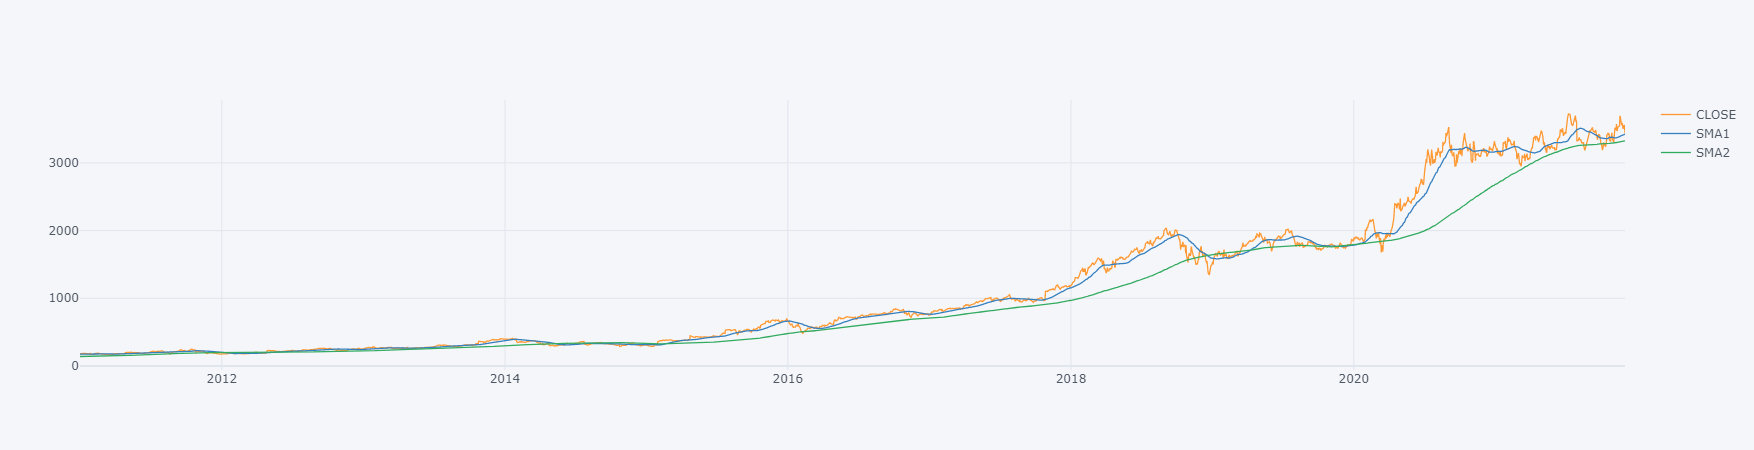

The purpose of the simple MA method has been accomplished as the time-series has been smoothed by both SMAs. Clearly, the long period MA is smoother than the short period one. 

However, it is still quite unclear where buy (or sell) signals lay.

## Strategy Visualization
As we stated above, the reasoning of SMA is to be long when the short period MA is above the long period one, and it is to be short in the other case. To better visualize such a strategy, we represent the long position by `+1` and a short position by `-1`.

In [ ]:
data['POSITIONS'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [ ]:
data.iplot(secondary_y='POSITIONS')

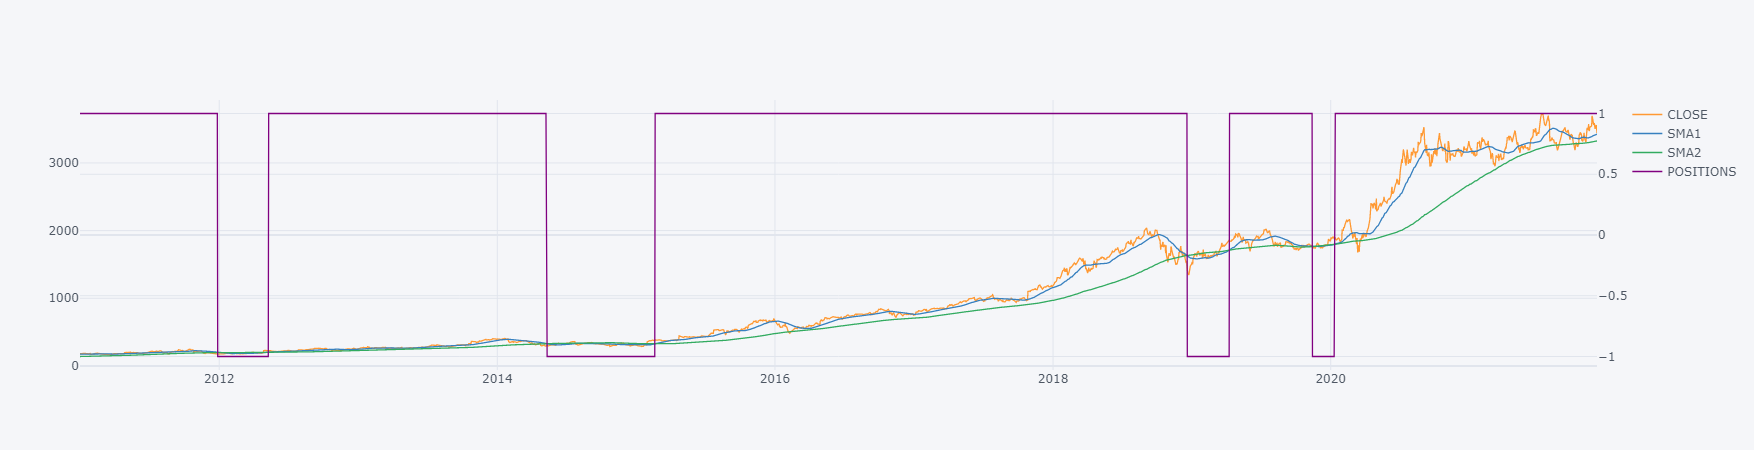

## A vectorized backtest
Backtesting is used to simulate the past performance of a trading strategy. The generated profit are often compared against a benmark performance, e.g., annualized returns. Vectorized backtesting is a fast backtesting technique which is used in the explorative stage of strategy research. 

Log-returns are particularly usefull.

$ \text{r}_t = log(\dfrac{p_t}{p_{t-1}}) = log(p_t)-log(p_{t-1})$

Consider the log-returns of an asset over three days $t=(1, 2,3)$. To compute the total return of the asset over the period, we sum the log-returns: $r_1+r_2+r_3$ 

$ = (log(p_3)-log(p_2))+(log(p_2)-log(p_1))+(log(p_1)-log(p_0))$

$ = (log(p_3)-log(p_0))$

$ = log(\dfrac{p_3}{p_0})$

The backtest of the strategy, i.e., calculating the returns of the strategy over the considered period, is equal to compute the comulative sum of log-returns, followed by the exponential function.

In [ ]:
data['RETURNS'] = np.log(data['CLOSE'] / data['CLOSE'].shift(1))  # log returns in vectorized fashion

In [ ]:
data['RETURNS'].head()

Date
2010-12-31        <NA>
2011-01-03    0.023174
2011-01-04    0.004279
2011-01-05    0.012942
2011-01-06   -0.008358
Name: RETURNS, dtype: Float64

In [ ]:
data.dropna(inplace=True)

In [ ]:
data['RETURNS'].iplot()

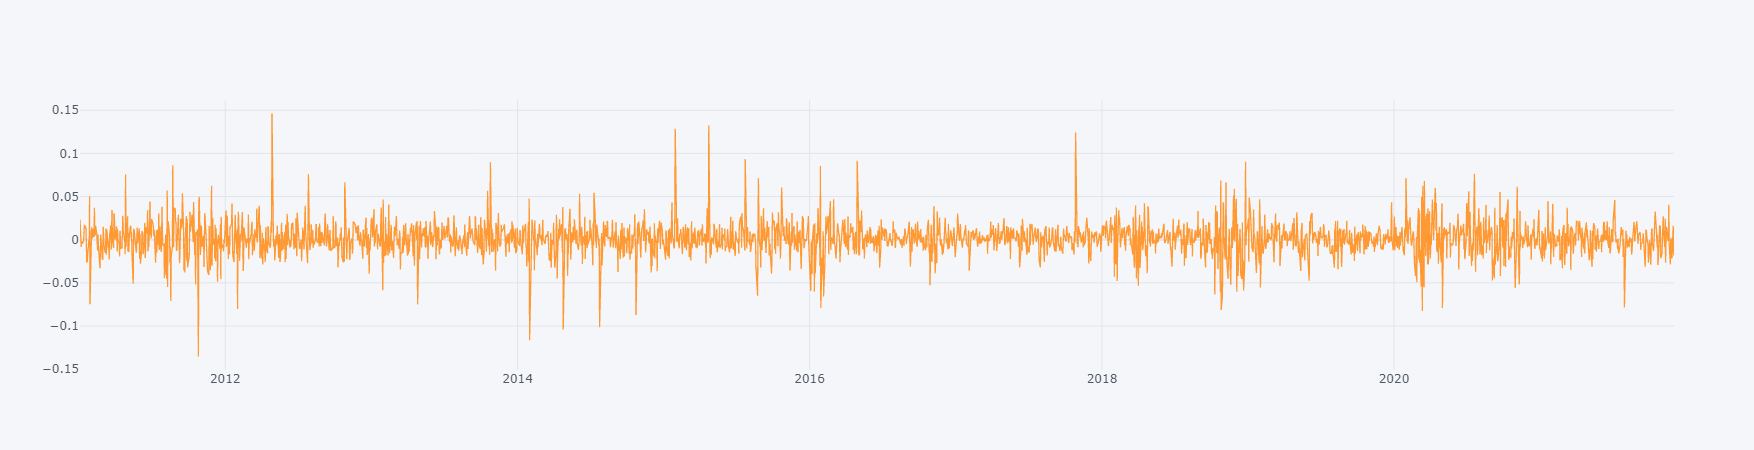

In [ ]:
data.head(2)

AMZN.O,CLOSE,SMA1,SMA2,POSITIONS,RETURNS
Date,,,,,
2011-01-03,184.22,174.541429,139.341281,1,0.023174
2011-01-04,185.01,174.935238,139.540963,1,0.004279


### Calculating the return of the strategy
The next step is to derive the returns of the strategy, by mutliplying the positionings (shifted by one day to avoid a foresight bias) with the stock returns. A long position earns the stock return, a short position earns the negative value of the stock return.

In [ ]:
data['strategy'] = data['POSITIONS'].shift(1) * data['RETURNS']

In [ ]:
data.head(2)

AMZN.O,CLOSE,SMA1,SMA2,POSITIONS,RETURNS,strategy
Date,,,,,,
2011-01-03,184.22,174.541429,139.341281,1,0.023174,NaN
2011-01-04,185.01,174.935238,139.540963,1,0.004279,0.004279


In [ ]:
data.dropna(inplace=True)

In [ ]:
data = data.iloc[1: , :]

In [ ]:
data.head(5)

AMZN.O,CLOSE,SMA1,SMA2,POSITIONS,RETURNS,strategy
Date,,,,,,
2011-01-04,185.01,174.935238,139.540963,1,0.004279,0.004279
2011-01-05,187.42,175.375476,139.759892,1,0.012942,0.012942
2011-01-06,185.86,175.734762,139.981559,1,-0.008358,-0.008358
2011-01-07,185.49,176.056190,140.187789,1,-0.001993,-0.001993
2011-01-10,184.68,176.399286,140.403551,1,-0.004376,-0.004376


The final step is to add up the single resulting log returns over time and to apply the exponential functions to arrive at the performance of the strategy compared to the benchmark of a passive investment in the stock.

In [ ]:
np.exp(data[['RETURNS', 'strategy']].sum())

AMZN.O
RETURNS     18.693519
strategy     3.689030
dtype: float64

In [ ]:
data[['RETURNS', 'strategy']].cumsum().iplot()

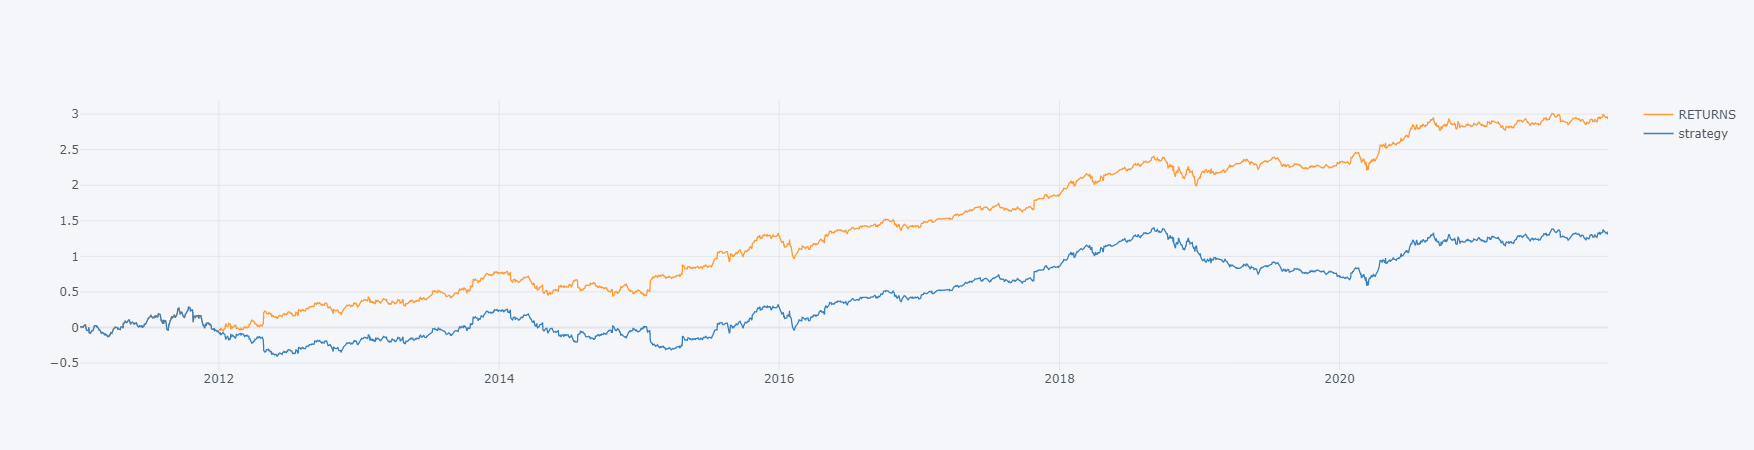

The performance of the strategy can also be compared over time to the benchmark investment.